In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Convolution1D, MaxPooling1D, Flatten

In [2]:
# Assuming y_pred and y_test are NumPy arrays containing the predicted and actual values
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from keras.models import Model
from keras.optimizers import Adam

# Residual Block Definition
def residual_block(x, filters, kernel_size=100, stride=1):
    shortcut = x
    
    x = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

# Define the ResNet Model
def ResNet1D(input_shape, num_filters, num_blocks, num_classes, kernel_size):
    inputs = Input(shape=input_shape)
    x = Conv1D(num_filters, kernel_size=kernel_size, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    for _ in range(num_blocks):
        x = residual_block(x, num_filters, kernel_size=kernel_size)
    
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='linear')(x)
    
    model = Model(inputs, outputs)
    return model

In [4]:
def ResNet(train, test, epoch):
    files = ['fpt', 'cmg', 'elc']
    for file in files:
        df = pd.read_csv(f'../../IS403_O21_14/Dataset/{file}_data_final.csv', index_col='Date')
        df.index = pd.to_datetime(df.index)

        dataset = df.values
        # 3. Scaler data
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(np.array(dataset))
        
        # 4. Chia train test
        train_size = int(train * len(scaled_data))
        test_size = int(test * len(scaled_data))

        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:train_size+test_size]
        train_data, test_data

        def create_dataset(dataset, time_step=1):
            dataX, dataY = [], []
            for i in range(len(dataset)-time_step-1):
                a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
                dataX.append(a) # here X is data 100 days before
                dataY.append(dataset[i + time_step, 0]) # here Y is day 101 (which is will be predicted using X)
            return np.array(dataX), np.array(dataY)

        time_step = 100 # use 100 days before to predict the next day
        X_train, y_train = create_dataset(train_data, time_step)
        X_test, y_test = create_dataset(test_data, time_step)
        
        # 7. Reshape input to be [samples, time steps, features] which is required for LSTM
        X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
        X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

        print('X_train: ' + str(X_train.shape))

        # 8. Define ResNet Model
        input_shape = (100, 1)
        num_filters = 64
        num_blocks = 3
        num_classes = 1
        kernel_size = time_step

        model = ResNet1D(input_shape, num_filters, num_blocks, num_classes, kernel_size)
        model.compile(loss='mean_squared_error', optimizer='adam')

        # 9. Fit mô hình với dữ liệu train
        model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=False)

        # 10. Dự báo dữ liệu test
        train_predict=model.predict(X_train)
        y_pred=model.predict(X_test)
        

        # Calculate RMSE
        rmse = calculate_rmse(y_test, y_pred)
        print(f'RMSE {file.upper()}:', rmse)

        # Calculate MAE
        mae = calculate_mae(y_test, y_pred)
        print(f'MAE {file.upper()}:', mae)

        # Calculate MAPE
        mape = calculate_mape(y_test, y_pred)
        print(f'MAPE {file.upper()}:', mape)

        # 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
        train_predict=scaler.inverse_transform(train_predict)
        y_pred=scaler.inverse_transform(y_pred)

        # Assuming you have already prepared your dataset and trained your model

        # Step 3: Generate input sequences for prediction
        # Use the last time_step observations from your dataset to generate input sequences for prediction
        last_observation = scaled_data[-time_step:]  # Assuming dataset is your time series data
        input_sequence = last_observation.reshape((1, time_step, 1))  # Reshape input for prediction

        # Step 4: Make predictions
        predictions = []  # List to store predictions for the next 30 days

        for _ in range(90):
            # Predict the next day's value
            next_day_prediction = model.predict(input_sequence)[0][0]  # Assuming model is your trained model
            predictions.append(next_day_prediction)
            
            # Update input sequence for the next prediction
            input_sequence = np.append(input_sequence[:, 1:, :], [[[next_day_prediction]]], axis=1)

        predictions = np.array(predictions)
        predict30days = predictions[:30]
        predict60days = predictions[29:61]
        predict90days = predictions[60:]

        # 14.Vẽ hình
        train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
        plt.title(f'{file.upper()}')
        plt.plot(scaler.inverse_transform(train_data))

        test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
        plt.plot(test_data_index,scaler.inverse_transform(test_data))

        test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
        plt.plot(test_data_index,(y_pred))

        prediect_30_index = pd.RangeIndex(start=len(df)-1, stop=len(scaled_data)+29, step=1)
        plt.plot(prediect_30_index, scaler.inverse_transform(predict30days.reshape(-1, 1)))

        prediect_60_index = pd.RangeIndex(start=len(scaled_data)+28, stop=len(scaled_data)+60, step=1)
        plt.plot(prediect_60_index, scaler.inverse_transform(predict60days.reshape(-1, 1)))

        prediect_90_index = pd.RangeIndex(start=len(scaled_data)+59, stop=len(scaled_data)+89, step=1)
        plt.plot(prediect_90_index, scaler.inverse_transform(predict90days.reshape(-1, 1)))

        plt.legend(['Train','Test','Test Predict','Predict30days', 'Predict60days', 'Predict90days'])
        plt.show()


X_train: (1723, 100, 1)
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
RMSE FPT: 0.19757370336175611
MAE FPT: 0.15590022026761585
MAPE FPT: 22.797933164696612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━

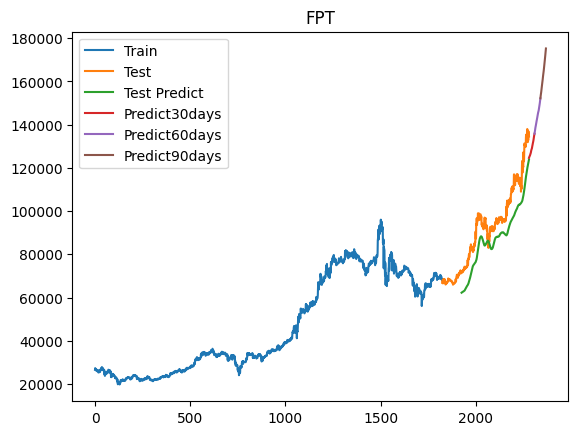

X_train: (1723, 100, 1)
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step
RMSE CMG: 0.1379577082296214
MAE CMG: 0.10258568981783248
MAPE CMG: 18.013811226501737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49m

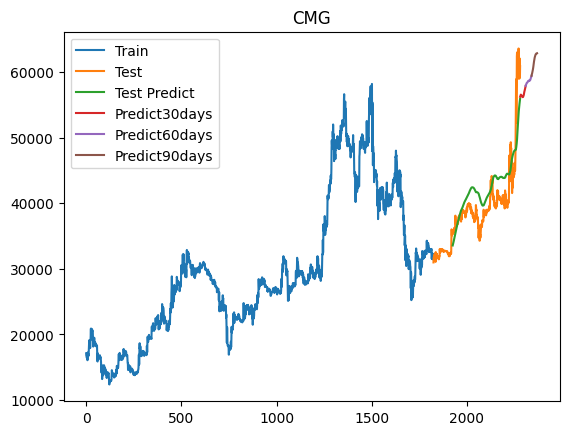

X_train: (1723, 100, 1)
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
RMSE ELC: 0.38706051995114454
MAE ELC: 0.3256890408489039
MAPE ELC: 67.47042020956619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

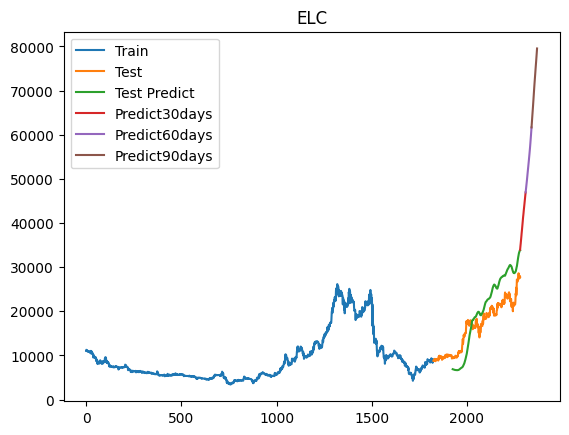

In [5]:
ResNet(0.8, 0.2, epoch=10)

X_train: (1951, 100, 1)
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
RMSE FPT: 0.440784985409755
MAE FPT: 0.42652991104923865
MAPE FPT: 52.33396908359245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━

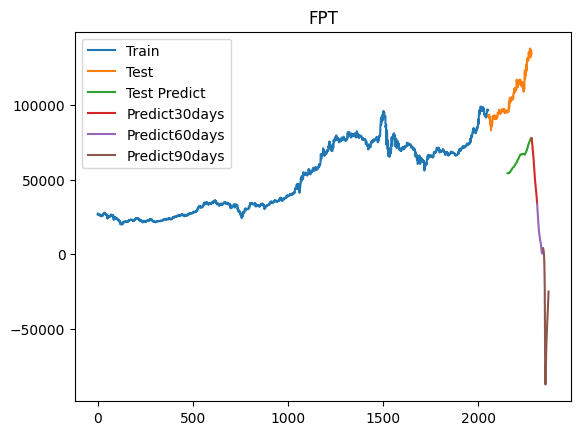

X_train: (1951, 100, 1)
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
RMSE CMG: 0.33695440359368695
MAE CMG: 0.29795853408732226
MAPE CMG: 44.32651929053549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━

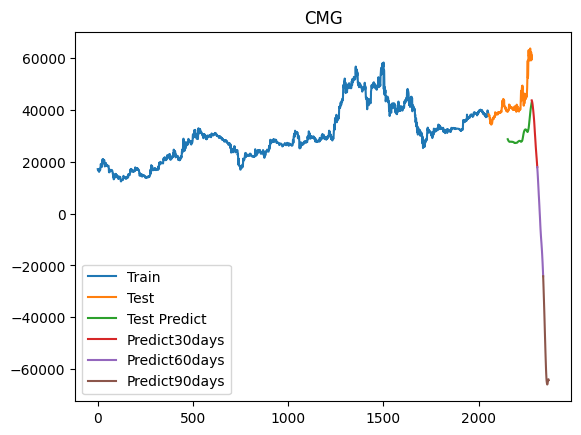

X_train: (1951, 100, 1)
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
RMSE ELC: 0.20198593105615292
MAE ELC: 0.1774814458831675
MAPE ELC: 22.13167234904421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

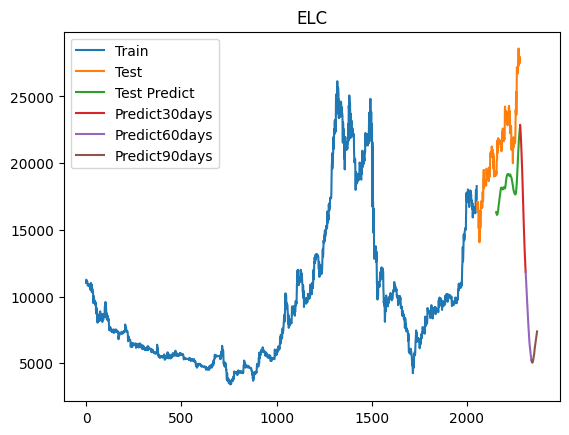

In [6]:
ResNet(0.9, 0.1, epoch=10)

X_train: (1495, 100, 1)
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
RMSE FPT: 0.1972705231748106
MAE FPT: 0.15380621031373667
MAPE FPT: 26.189133548486428
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

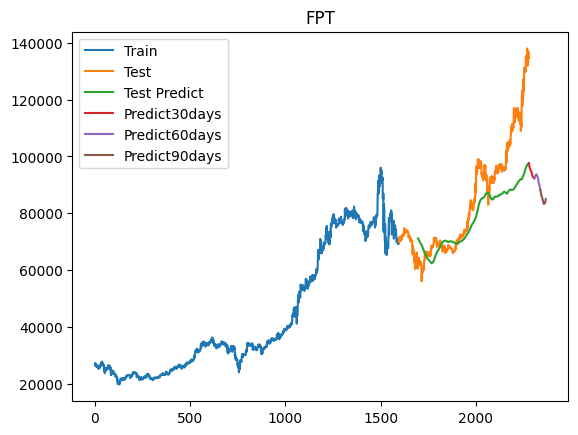

X_train: (1495, 100, 1)
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
RMSE CMG: 0.21353467357772477
MAE CMG: 0.17072878323023788
MAPE CMG: 32.25118015702479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

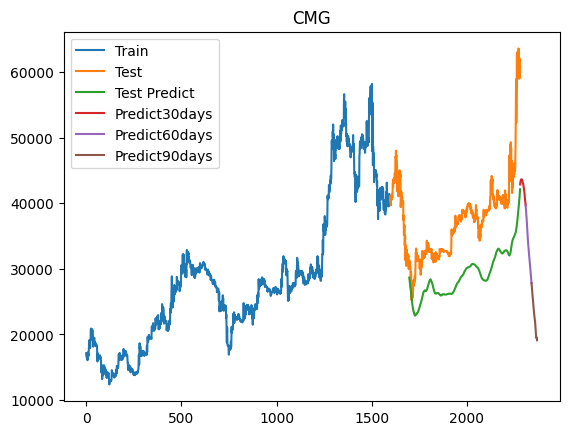

X_train: (1495, 100, 1)
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
RMSE ELC: 0.3752398555475942
MAE ELC: 0.293899560665274
MAPE ELC: 59.00190403894501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

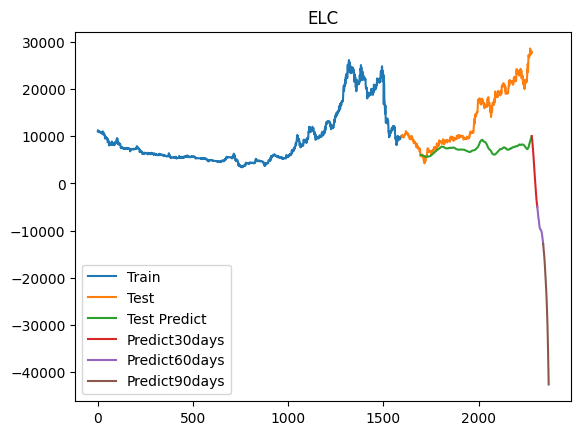

In [7]:
ResNet(0.7, 0.3, epoch=10)